# Portfolio Optimization
**Portfolio optimization** is the decade-old mathematical practise of experimenting with different weight allocations over $N$ different asets to create a combination that minimizes risk while maximizing returns. 

In this notebook, I take a closer look at the **mean-variance portfolio (MVP)** proposed by Markowitz in 1952, and the different ways it can be improved. 

Before diving into the code, please consult the read.me document for information regarding limitations, assumptions and more.

Be aware of the results from the proposed models: they should not be seen as financial advice.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import cvxpy as cp # library for convex optimization problems

import os

from datetime import datetime
import pandas_market_calendars as mcal # library for market calendars

import matplotlib.pyplot as plt

In [2]:
# Initialize global variables
# Load data
opt_dates = os.listdir("assets")
historical_data = pd.read_csv("historical_data.csv").set_index("Date")
historical_data = historical_data.dropna(axis=1, how='any')

# Indexes for iteration
start_idx = 0
end_idx = len(opt_dates) - 1
lookback = 756

# Memories 
all_rets = {}
all_turns = {}
all_w = {}
prev_weights = {}

# Obtain formatted dates
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule('2000-01-01','2030-01-01')
trading_days = schedule.index

all_dates = list(historical_data.index)
all_dates = [ int(datetime.strptime(x, '%Y-%m-%d').strftime('%Y%m%d')) for x in all_dates ]

## Portfolio Optimization Functions

### **Mean-Variance Portfolio (MVP)**
The MVP maximizes $w$ in: $$w’ \mu - \frac{\lambda}{2}w’ \Sigma w$$ subject to $1’w=1$ and $w \ge 0$, where $\mu$ is the expected returns, $\Sigma$ is the covariance matrix, and $\lambda$ is a hyper-parameter that controls how risk averse the investor is. 

Because in reality we don't know $\mu$ and $\Sigma$, we estimate them using sample Gaussian estimators:
- $\hat{\mu} = \frac{1}{T}\sum x_t$
- $\hat{\Sigma} = \frac{1}{T-1}\sum (x_t - \hat{\mu})(x_t - \hat{\mu})'$

Where $x_t$ are the returns of an asset, $t$ is the selected time window, and $T$ is the number of historical observations.

In [3]:
# Vanilla MVP function with lambda = 1
def MVP_lmd(X_log, lmd=1):
    # Estimate mu and Sigma with training data
    mu = X_log.mean().values
    sigma = X_log.cov().values

    # Initialize variables and constraints
    N = len(sigma)
    weights = cp.Variable(N) # Vector variable "weights" of size N that will be optimized using train data. 
    constraints = [cp.sum(weights) == 1, weights >= 0] # Define capital budget, and long-only constraint

    prob = cp.Problem(cp.Maximize(mu @ weights - (lmd/2) * cp.quad_form(weights, sigma)), constraints) # Form the problem (formula above)
    prob.solve() # Find the optimal value of the problem above 
    return weights.value # Return a vector containing optimal weight allocations across the N assets

#### *Improvement 1: Diversification constraint*
Even with robust estimation, the MVP remains structurally unstable due to its tendency toward concentration, motivating the use of explicit diversification constraints. 
The quantity $\sum^N_{i=1}w^2_i=||w||^2_2$ is known as the Herfindahl index of the weights and can be used as a diversification measure. The lower its value, the higher the level of diversification. 

We define the constraint as: $$||w||^2_2 \le D$$
Where $D \le \frac{5}{N}$ for the sake of convex programming rules.

In [4]:
# Function for optimizing weights given any estimator for mu and sigma
def design_MVP(mu, sigma, lmd):
    # Initialize variables and constraints
    N = len(sigma)
    weights = cp.Variable(N) 

    # Define diversification constraint in addition to existing
    constraints = [cp.sum(weights) == 1, 
                   weights >= 0,
                   cp.sum_squares(weights) <= 5/N] 

    prob = cp.Problem(cp.Maximize(mu @ weights - (lmd/2) * cp.quad_form(weights, sigma)), constraints) 
    prob.solve()
    return weights.value

In [5]:
# Function for computing Gaussian estimators
def gaus_MVP(X_log):
    # Estimate mu and Sigma with training data
    mu = X_log.mean().values
    sigma = X_log.cov().values
    return mu, sigma

In [6]:
# MVP function with added diversification constraint
def dMVP(X_log, lmd=1):
    mu, sigma = gaus_MVP(X_log)
    weights = design_MVP(mu, sigma, lmd)
    return weights

#### *Improvement 2: Cross-validating $\lambda$*

Instead of having a fixed $\lambda$, we could use cross-validation within the in-sample data to determine it based on Sharpe ratio, making the MVP more adaptable in volatile periods. This is useful, as the performance for each lambda is different. 

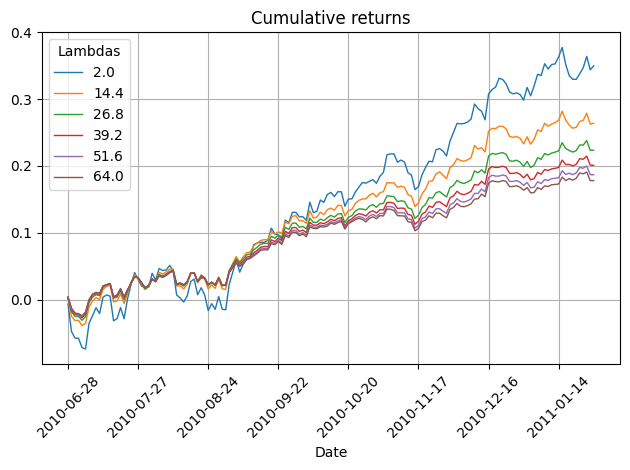

In [7]:
# Test showing the essence of choosing the right lambda
X_lin = historical_data["2009-01-30":"2011-01-31"].pct_change().dropna()
X_log = np.log1p(X_lin)

T = X_lin.shape[0]
T_split = round(0.70*T)

X_log_trn = X_log[:T_split]
X_lin_val =  X_lin[T_split:]

dif_lmds = np.linspace(2, 64, 6)
rets_lmds = {}

for lmd in dif_lmds:
    mu, sigma = gaus_MVP(X_log_trn)
    w_MVP = design_MVP(mu, sigma, lmd)
    ret_MVP = X_lin_val @ w_MVP
    cum_ret = (1 + ret_MVP).cumprod() - 1
    cum_ret.plot(label=lmd, linewidth=1)

plt.title('Cumulative returns')
plt.legend(title='Lambdas')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
# Function for cross-validating lambda in MVP: called in backtest()
def estimate_lmd(X_lin, lambdas):
    X_log = np.log1p(X_lin)
    lmd_performance = {}
    
    # Split in-sample data in 70-30 train data and validation data
    T = X_lin.shape[0]
    T_split = round(0.70*T)

    X_log_trn = X_log[:T_split]
    X_lin_val =  X_lin[T_split:]

    # Compute weights and returns for each lambda
    for lmd in lambdas:
        mu, sigma = gaus_MVP(X_log_trn)
        w_MVP = design_MVP(mu, sigma, lmd)
        ret_MVP = X_lin_val @ w_MVP

        # Measure performance based on Sharpe ratio
        sharpe_ratio = ret_MVP.mean() / (ret_MVP.std() + 1e-8)
        lmd_performance[lmd] = sharpe_ratio

    # Use the lambda with the highest Sharpe ratio
    best_lmd = max(lmd_performance, key=lmd_performance.get)
    print(f"The best lambda value is {best_lmd} with a Sharpe ratio of {lmd_performance[best_lmd]}")
    return best_lmd

In [9]:
# MVP function with added diversification constraint and cross-validation for lambda
def dMVP_blmd(X_log, best_lmd):
    mu, sigma = gaus_MVP(X_log)
    weights = design_MVP(mu, sigma, best_lmd)
    return weights

#### *Improvement 3: Shrinkage*
Shrinkage introduces a little bias in the estimators in order to reduce their estimation error and involves the bias-variance trade-off concept. The estimation error can be measured by the Mean Squared Error: $\text{MSE}(\hat{\theta})=\text{Var}(\hat{\theta}) + \text{Bias}^2(\hat{\theta})$.

Because we don't have enough observations $T$, the variance dominates the overall MSE of the estimator while the bias is reduced, contrary to large sample regimes. An idea would be to allow for some bias by weighting the estimator with a target estimation in order to achieve an overall smaller MSE. We define: $$\hat{\theta^{\text{sh}}} = (1 - p)\hat{\theta} + p \theta^{\text{tgt}}$$

Where $p$ with $0 \le p \le 1$ is the shrinkage factor, and $\theta^{\text{tgt}}$ represents the target estimation which can be anything for both $\mu$ and $\Sigma$. For the sake of simplicity, the $\mu^{\text{tgt}}$ will be the zero vector, and $\Sigma^{\text{tgt}}$ will be the scaled identity covariance structure. 

In [10]:
# Function for shrinking the mu estimator
def shrinkage(X_log, mu, sigma):
    T, N = X_log.shape
    mu_tgt = np.zeros(N)

    # Shrink mu
    diff = mu - mu_tgt
    rho = (N + 2) / ((N + 2) + T * np.dot(diff, np.linalg.solve(sigma, diff))) # James-Stein estimator
    rho = max(0, min(1, rho))
    mu_sh = (1 - rho) * mu + rho * mu_tgt

    # Shrink sigma
    Xc = X_log - mu
    sigma_tgt = np.mean(np.diag(sigma)) * np.eye(N)
    rho = min(1, ((1/T**2) * np.sum(np.sum(Xc**2, axis=1)**2) - 1/T * np.sum(sigma**2)) / np.sum((sigma - sigma_tgt)**2))
    sigma_sh = (1 - rho) * sigma + rho * sigma_tgt
    return mu_sh, sigma_sh

In [11]:
# MVP function with added diversification constraint, cross-validation for lambda and shrinkage
def sh_dMVP_blmd(X_log, best_lmd):
    mu, sigma = gaus_MVP(X_log)

    # Shrink computed estimators
    mu_sh, sigma_sh = shrinkage(X_log, mu, sigma)
    weights = design_MVP(mu_sh, sigma_sh, best_lmd)
    return weights

#### *Improvement 4: Non-Gaussian estimators of $\mu$ and $\Sigma$*

An argument in favour of the sample estimators would be that both are said to be unbiased and consistent by the LLN under the assumptions of i.i.d. sampling with finite second order moments, meaning the estimation error goes to zero as $T$ goes to infinity. 

In reality, this isn’t plausible for two reasons:
- It is hard to find 'enough' historical data for each asset. 
- Even if we did have the data, the market conditions have changed significantly in the course of a few years. 

Additionally, the distribution of financial data is non-Gaussian, as it is generally slightly right skewed and has thicker tails, while the asset structure has a strong dependence. A more accurate representation of the data's distribution is the **student t($\nu$)-distribution**, which approximates the Gaussian distribution as $\nu \to \infty$. As a result, the sample estimators of $\mu$ and $\Sigma$ may not deem appropriate because small estimation errors are amplified by the optimizer, leading to extreme and unstable portfolios.

Instead of assuming a Gaussian distribution, we should adjust our estimators accordingly. We define the maximum likelihood estimators under the t-distribution as:
- $\tilde{\mu} = \frac{\frac{1}{T}\sum^{T}(w_{t}(\mu, \Sigma) \times x_{t})}{\frac{1}{T}\sum^{T}(w_{t}(\mu, \Sigma))}$
- $\tilde{\Sigma} = \frac{1}{T}\sum^{T}(w_{t}(\mu,\Sigma)\times(x_{t}-\tilde{\mu})(x_{t}-\tilde{\mu})')$

Where $w_{t}(\mu, \Sigma)=\frac{v+N}{v+(x_{t}-\mu)'\Sigma^{-1}(x_{t}-\mu)}$ is a decreasing function of the Mahalanobis distance, meaning observations far from the center of the distribution receive less influence.

In [12]:
# Function for computing heavy-tailed maximum likelihood estimators
def hML_MVP(X_log, max_iter=20, tol=1e-4):
    T, N = X_log.shape
    nu = 4 # degrees of freedom

    # Estimate sample mu and covariance with training data
    mu = X_log.mean()
    cov = X_log.cov()
    sigma = (nu - 2)/nu * cov # Comform 2nd moment

    for _ in range(int(max_iter)):
        mu_prev = mu.copy()
        sigma_prev = sigma.copy()

        # Compute Mahalanobis distance
        Xc = X_log - mu
        r2 = np.sum(Xc * np.linalg.solve(sigma + 1e-6 * np.eye(N), Xc.T).T, axis=1)

        # Update weights
        wt = (nu + N) / (nu + r2)

        # Update mu and sigma
        mu = np.mean(X_log * wt.values[:, None], axis=0) / np.mean(wt)
        Xc = X_log - mu
        sigma = (1 / T) * np.dot((Xc * np.sqrt(wt).values[:, None]).T, Xc * np.sqrt(wt).values[:, None]) / np.mean(wt)

        # Stop criterion: check for convergence (mu and sigma stop moving)
        if np.linalg.norm(mu - mu_prev) < tol and np.linalg.norm(sigma - sigma_prev) < tol:
            break

    # Convert back to covariance
    sigma_cov = nu / (nu - 2) * sigma
    return mu.values, sigma_cov

In [13]:
# MVP function with added diversification constraint, cross-validation for lambda, shrinkage and heavy tailed estimators
def sh_hML_dMVP_blmd(X_log, best_lmd):
    mu, sigma = hML_MVP(X_log, best_lmd)

    # Shrink computed estimators
    mu_sh, sigma_sh = shrinkage(X_log, mu, sigma)
    weights = design_MVP(mu_sh, sigma_sh, best_lmd)
    return weights

### **Equally Weighted Portfolio (EWP)**
The EWP portfolio is a well-known heuristic portfolio that allocates the capital equal over the $N$ assets, such that: $$w=\frac{1}{N} \times 1$$
In this context, it will be used as a benchmark.

In [14]:
# Equally Weighted Portfolio function
def EWP(X_log):
    N = X_log.shape[1]
    return np.repeat(1/N, N)

## Walk-forward Backtesting
Instead of dividing the historical data into the classic in-sample and out-sample dataset, the data is divided into dynamic training windows that each reoptimize the portfolio as new data becomes available. This is known as the walk-forward backtest, and effectively mimicks the way it would be done in live trading. 

In [15]:
# Function that finds the lookback day necessary for the in-sample dataset window   
def shift_trading_days(start_date, lookback=252):
    start_date = pd.Timestamp(start_date)
    idx = trading_days.get_loc(start_date)
    return trading_days[idx - lookback]

In [16]:
# Function for backtesting the vanilla MVP 
def backtest(portf_funcs, 
            prev_weights,
            prices: pd.DataFrame,
            str_test: str,
            end_test: str,
            lookback: int=252,
            rebalance: int=1,
            cost_bps: int=0):
    
    # Calculate linear and logarithmic returns; Remove NaN to prevent errors
    X_lin = prices.pct_change().dropna()
    X_log = np.log1p(X_lin)

    # Define train and test data
    lkback_date = shift_trading_days(str_test, lookback)
    X_lin_test =  X_lin[str_test:end_test]
    X_log_trn = X_log[str(lkback_date):str_test]

    portf_rets = {}
    portf_turns = {}
    portf_ws = {}
    old_weights = {}

    # Estimate lambda using cross-validation 
    print("Cross-validating lambda based on Sharpe ratio...")
    lambdas = np.linspace(1, 64, 25)
    best_lmd = estimate_lmd(X_lin, lambdas)

    for portf_name, portf_func in portf_funcs.items():
        print(f"\nCommencing backtest for {portf_name}...")
        # Initialize variables
        N = X_log.shape[1] 
        current_w = np.repeat(0, N) 
        portf_ret = pd.Series(index=X_log.index)
        portf_turn = pd.Series(index=X_log.index)
        portf_w = pd.DataFrame(index=X_log.index, columns=X_log.columns) 

        # Design portfolio weights
        print("Designing weights...")
        if "cv lmd" in portf_name:
            og_w = pd.Series(portf_func(X_log_trn, best_lmd), index=X_log_trn.columns)
        else:
            og_w = pd.Series(portf_func(X_log_trn), index=X_log_trn.columns)

        # Backtest portfolio day-to-day with test data
        print("Computing returns...")
        for t_idx, t in enumerate(X_lin_test.index):
            # Store weights
            trans_costs = 0.0
            if t_idx == 0: # Reoptimization
                if portf_name in prev_weights:
                    w_prev, w_new = prev_weights[portf_name].align(og_w, fill_value=0.0)
                    turnover = np.abs(w_prev - w_new).sum()
                    #turnover = np.abs(prev_weights[portf_name] - og_w).sum()
                else:
                    turnover = np.abs(current_w - og_w).sum()
            elif t_idx % rebalance == 0: # Rebalancing
                turnover = np.abs(current_w - og_w).sum()
            
            # Compute and save transactional costs
            portf_turn.loc[t] = turnover
            trans_costs = turnover * cost_bps / 1e4
            current_w = og_w
            portf_w.loc[t] = current_w

            # Compute portfolio return
            period_ret = X_lin_test.loc[t] @ current_w
            portf_ret.loc[t] = period_ret - trans_costs

            # Normalize weights based on asset performance to simulate weight drift
            current_w = current_w * (1 + X_lin_test.loc[t])
            current_w = current_w / current_w.sum()

        # Save returns and weights to each portfolio function
        portf_rets[portf_name] = portf_ret.dropna()
        portf_turns[portf_name] = portf_turn.dropna()
        portf_ws[portf_name] = portf_w.dropna(how="all")

        # Save current weights
        old_weights[portf_name] = og_w.copy()
        print("Done!")

    return portf_rets, portf_turns, portf_ws, old_weights


In [17]:
# Will cycle through the monthly constituents and backtest the portfolios with the available data
def run_PO(portf_funcs, start_idx, end_idx):
    while start_idx < end_idx:
        # Load constituents and save ones we have price data for as "exst_consts"
        consts = pd.read_csv("assets\\" + opt_dates[start_idx]).set_index("rank")
        exst_consts = set(consts["ticker"]).intersection(historical_data.columns)
        exst_consts = historical_data[list(exst_consts)]

        try:
            # Obtain the train + test data of the reoptimization period
            str_test = datetime.strptime(opt_dates[start_idx][6:-4], '%Y%m%d').strftime('%Y-%m-%d')
            end_test = datetime.strptime(str(int(opt_dates[start_idx + 1][6:-4]) - 1), '%Y%m%d').strftime('%Y-%m-%d')
            exst_data = exst_consts.loc[:str(end_test)]

            # Conduct backtest with weekly rebalancing and transaction costs of 0.30% per trade
            print(f"Running backtest {start_idx}. Reoptimization as of: {str_test}")
            portf_ret, portf_turn, portf_w, new_prev_weights = backtest(portf_funcs, prev_weights, exst_data, str_test, end_test, lookback, 5, 30)
            prev_weights.update(new_prev_weights)
            print("Backtesting completed \n")

        except:
            print(f"No data available for {str_test} or {end_test}!")
            # Obtain the train + test data through closest date to the reoptimization period
            closest_start = min(all_dates, key=lambda x:abs(x - int(opt_dates[start_idx][6:-4])))
            format_closest_start = datetime.strptime(str(closest_start), '%Y%m%d').strftime('%Y-%m-%d')
            closest_end = min(all_dates, key=lambda x:abs(x - int(opt_dates[start_idx + 1][6:-4])))
            exst_data = exst_consts.loc[:str(closest_end)]

            # Retry backtest with weekly rebalancing and transaction costs of 0.30% per trade
            print(f"Retrying backtest {start_idx}. Reoptimization as of: {format_closest_start}")
            portf_ret, portf_turn, portf_w, new_prev_weights = backtest(portf_funcs, prev_weights, exst_data, str(closest_start), str(closest_end), lookback, 5, 30)
            prev_weights.update(new_prev_weights)
            print("Backtesting completed \n")
        
        # Concatenate returns and weights to previous period
        for portf in portf_funcs:
            all_rets[portf] = pd.concat([all_rets[portf], portf_ret[portf]])
            all_turns[portf] = pd.concat([all_turns[portf], portf_turn[portf]])
            all_w[portf] = pd.concat([all_w[portf], portf_w[portf]])

        start_idx += 1

    return all_rets, all_w

In [18]:
# Include portfolio functions for testing 
portf_funcs = {"EWP": EWP, 
               "Vanilla MVP":MVP_lmd,
               "Vanilla MVP w/ div.":dMVP,
               "MVP w/ div. + cv lmd":dMVP_blmd,
               "Shr. MVP w/ div. + cv lmd":sh_dMVP_blmd,
               "Shr. hML MVP w/ div. + cv lmd":sh_hML_dMVP_blmd}
for portf in portf_funcs:
    all_rets[portf] = pd.Series()
    all_turns[portf] = pd.Series()
    all_w[portf] = pd.DataFrame()

run_PO(portf_funcs, start_idx, end_idx)

Running backtest 0. Reoptimization as of: 2009-01-30
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 1.0 with a Sharpe ratio of -0.05265663359969028

Commencing backtest for EWP...
Designing weights...
Computing returns...
Done!

Commencing backtest for Vanilla MVP...
Designing weights...
Computing returns...
Done!

Commencing backtest for Vanilla MVP w/ div....
Designing weights...
Computing returns...
Done!

Commencing backtest for MVP w/ div. + cv lmd...
Designing weights...
Computing returns...
Done!

Commencing backtest for Shr. MVP w/ div. + cv lmd...
Designing weights...
Computing returns...
Done!

Commencing backtest for Shr. hML MVP w/ div. + cv lmd...
Designing weights...
Computing returns...
Done!
Backtesting completed 

Running backtest 1. Reoptimization as of: 2009-02-27
Cross-validating lambda based on Sharpe ratio...


C:\Users\vladp\AppData\Local\Temp\ipykernel_28180\5416028.py:37: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_rets[portf] = pd.concat([all_rets[portf], portf_ret[portf]])
C:\Users\vladp\AppData\Local\Temp\ipykernel_28180\5416028.py:38: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_turns[portf] = pd.concat([all_turns[portf], portf_turn[portf]])
C:\Users\vladp\AppData\Local\Temp\ipykernel_28180\5416028.py:37: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty 

The best lambda value is 1.0 with a Sharpe ratio of -0.04865163602433817

Commencing backtest for EWP...
Designing weights...
Computing returns...
Done!

Commencing backtest for Vanilla MVP...
Designing weights...
Computing returns...
Done!

Commencing backtest for Vanilla MVP w/ div....
Designing weights...
Computing returns...
Done!

Commencing backtest for MVP w/ div. + cv lmd...
Designing weights...
Computing returns...
Done!

Commencing backtest for Shr. MVP w/ div. + cv lmd...
Designing weights...
Computing returns...
Done!

Commencing backtest for Shr. hML MVP w/ div. + cv lmd...
Designing weights...
Computing returns...
Done!
Backtesting completed 

Running backtest 2. Reoptimization as of: 2009-03-31
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 1.0 with a Sharpe ratio of -0.03184002655554707

Commencing backtest for EWP...
Designing weights...
Computing returns...
Done!

Commencing backtest for Vanilla MVP...
Designing weights...
Computing returns.

({'EWP': 2009-01-30   -0.032876
  2009-02-02   -0.007540
  2009-02-03    0.014635
  2009-02-04   -0.009245
  2009-02-05    0.019451
                  ...   
  2024-10-23   -0.002343
  2024-10-24   -0.000074
  2024-10-25   -0.005097
  2024-10-28    0.005097
  2024-10-29   -0.003838
  Length: 3943, dtype: float64,
  'Vanilla MVP': 2009-01-30   -0.020826
  2009-02-02    0.000747
  2009-02-03    0.018227
  2009-02-04    0.099418
  2009-02-05    0.016788
                  ...   
  2024-10-23   -0.016911
  2024-10-24   -0.002401
  2024-10-25    0.004222
  2024-10-28   -0.002186
  2024-10-29    0.009169
  Length: 3943, dtype: float64,
  'Vanilla MVP w/ div.': 2009-01-30   -0.016549
  2009-02-02   -0.003516
  2009-02-03    0.017858
  2009-02-04    0.001693
  2009-02-05    0.010967
                  ...   
  2024-10-23   -0.004299
  2024-10-24   -0.000195
  2024-10-25   -0.004491
  2024-10-28    0.003597
  2024-10-29   -0.005787
  Length: 3943, dtype: float64,
  'MVP w/ div. + cv lmd': 2009-01-

## Performance Measures
Below we asses the performance of our portfolios by:
- Cumulative returns
- Drawdown
- Annualized return
- Annualized volatility
- Annualized Sharpe
- Maximum drawdown
- Average Turnover

In [19]:
# Function for plotting cumulative returns
def plot_cum_rets(all_rets):
    plt.figure(figsize=(12, 6))
    for portf_name in all_rets:
        cum_ret = (1 + all_rets[portf_name]).cumprod() - 1
        cum_ret.plot(label=portf_name, linewidth=1)
    plt.title('Cumulative returns')
    plt.legend(title='Portfolios')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [20]:
# Function for plotting drawdown
def drawdown(all_rets):
    plt.figure(figsize=(12, 6))
    for portf_name in all_rets:
        cum_ret = (1 + all_rets[portf_name]).cumprod()
        run_max = cum_ret.cummax()
        drawdowns = (cum_ret - run_max) / run_max
        drawdowns.plot(label=portf_name, linewidth=1)
    plt.title('Drawdown')
    plt.legend(title='Portfolios')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [21]:
# Function for calculating maximum drawdown
def max_drawdown(portf_ret):
    cum_ret = (1 + portf_ret).cumprod()
    run_max = cum_ret.cummax()
    drawdowns = (cum_ret - run_max) / run_max
    max_dd = drawdowns.min()
    return max_dd

In [22]:
# Function for computing annualized returns, volatility and Sharpe ratio
def metrics_table(all_rets, rfr=0.0):
    d_rfr = rfr / 252 # Daily risk-free rate
    performance_table = pd.DataFrame(columns = ["Annualized Return", "Annualized Volatility", "Sharpe Ratio", "Max Drawdown", "Average Turnover"])
    
    for idx, portf_name in enumerate(all_rets):
        # Calculate annualized returns 
        T = all_rets[portf_name].shape[0]
        annual_ret = (1 + all_rets[portf_name]).prod() ** (252 / T) - 1

        # Calculate annualized volatility
        annual_vol = all_rets[portf_name].std() * np.sqrt(252)

        # Calculate annualized Sharpe ratio
        annual_sharpe = (annual_ret - d_rfr) / annual_vol
    
        # Calculate maximum drawdown
        max_dd = max_drawdown(all_rets[portf_name])

        # Calculate average turnover
        avg_turn = all_turns[portf_name].mean()

        # Add metrics to table
        performance_table.loc[idx] = [annual_ret, annual_vol, annual_sharpe, max_dd, avg_turn]
    
    performance_table.index = all_rets.keys()
    display(performance_table)

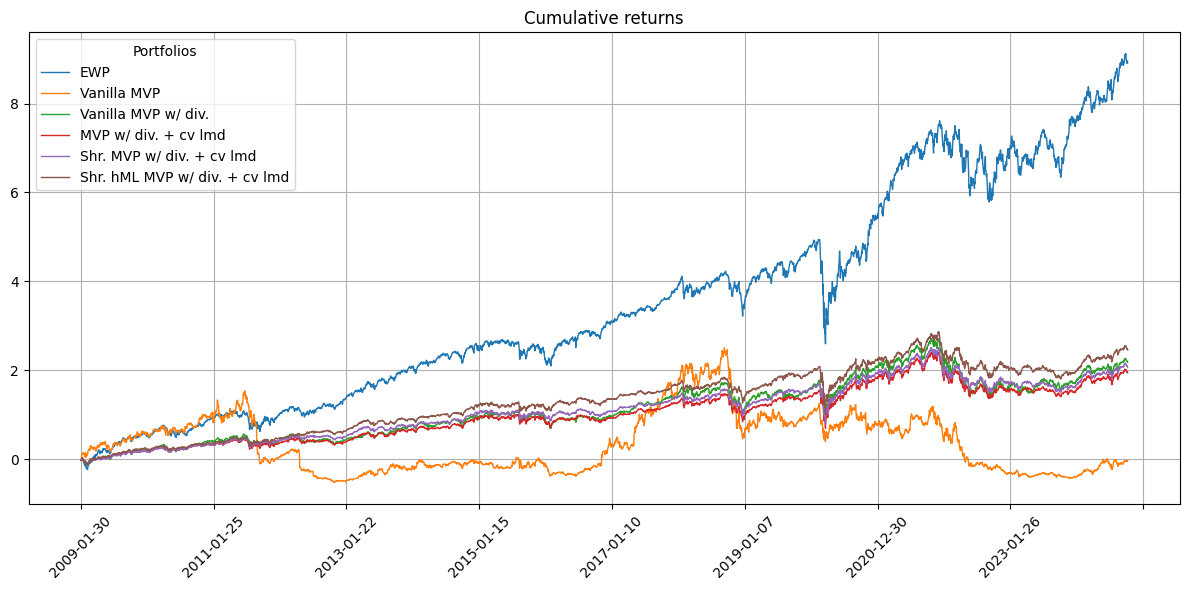

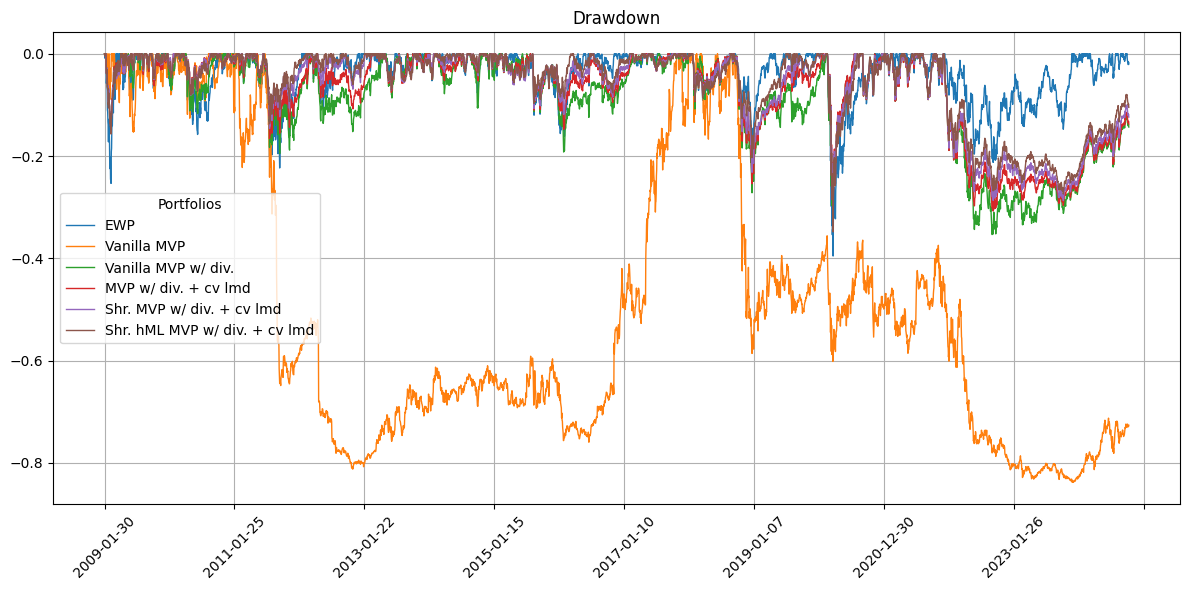

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Average Turnover
EWP,0.157933,0.193822,0.814833,-0.395514,0.010893
Vanilla MVP,-0.002726,0.396686,-0.006871,-0.837959,0.147690
Vanilla MVP w/ div.,0.076726,0.189489,0.404908,-0.353526,0.079953
MVP w/ div. + cv lmd,0.071377,0.162478,0.439304,-0.335171,0.084195
Shr. MVP w/ div. + cv lmd,0.074352,0.153524,0.484305,-0.337083,0.074296
Shr. hML MVP w/ div. + cv lmd,0.082421,0.147038,0.560541,-0.348399,0.063884


In [23]:
# Run all performance measure computations
plot_cum_rets(all_rets)
drawdown(all_rets)
metrics_table(all_rets, rfr=0.0)